In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from mpl_toolkits.axes_grid1 import AxesGrid

plt.style.use('ggplot')
path_project = "/home/igormago/projects/DeepFootball/"
sys.path.insert(1, path_project)
from conf.configparser import conf

In [2]:
countries_abv = {'Brazil A': 'BR1', 'Brazil B': 'BR2', 'England A': 'GB1', 'France A': 'FR1', 'Germany A': 'DE1', 'Italy A':'IT1', 'Netherlands A': 'NL1', 'Portugal A': 'PT1', 'Spain A': 'ES1' }
classifier_abv = {'XGBClassifier': 'XGB', 'GaussianNB': 'GNB', 'LogisticRegression': 'LRE', 'mkc': 'MKC', 'mcc':'MCC'}

def get_abv_list(countries):
    abv = list()
    for c in countries:
        abv.append(countries_abv[c])
        
    return abv

PATH_EXPERIMENTS = os.path.join(conf['path']['experiments'], 'btts_v2')

CLASSIFIERS = ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc', 'mcc']
CHAMPIONSHIPS =  ['Brazil A', 'Brazil B', 'England A', 'France A', 'Germany A', 'Italy A', 
                 'Netherlands A', 'Portugal A', 'Spain A']

exp1 = ['performance', 'default']
exp2 = ['market','default']
exp3 = ['total', 'default']
#EXPERIMENTS = [exp1, exp2, exp3]
EXPERIMENTS = [exp1, exp2, exp3]

CHAMPIONSHIP = 'm.ss.ch.nm'
RESULT = 'm.res.bts'
MODEL_PREDICTION = 'pred'
MARKET_PREDICTION = 'm.odds.f.bts.f.c'
MODEL_PROB_Y = 'pred_prob_y'
MODEL_PROB_N = 'pred_prob_n'

Y_ODD_MAX = 'm.odds.s.bts.y.o.max'
N_ODD_MAX = 'm.odds.s.bts.n.o.max'

Y_ODD_AVG = 'm.odds.s.bts.y.o.avg'
N_ODD_AVG = 'm.odds.s.bts.n.o.avg'

Y_PROB_AVG = 'm.odds.s.bts.y.t.avg'
N_PROB_AVG = 'm.odds.s.bts.n.t.avg'

BET_PR_BTS = 'bet.pred.res'
BET_PR_HIT = 'bet.pred.hit'
BET_PR_PL_AVG = 'bet.pred.pl.avg'
BET_PR_PL_MAX = 'bet.pred.pl.max'

BET_EV_BTS = 'bet.ev.res'
BET_EV_VAL_Y_AVG = 'bet.ev.val.y.avg'
BET_EV_VAL_N_AVG = 'bet.ev.val.n.avg'
BET_EV_VAL_Y_MAX = 'bet.ev.val.y.max'
BET_EV_VAL_N_MAX = 'bet.ev.val.n.max'

BET_EV_PL_Y_AVG = 'bet.ev.pl.y.avg'
BET_EV_PL_N_AVG = 'bet.ev.pl.n.avg'
BET_EV_PL_Y_MAX = 'bet.ev.pl.y.max'
BET_EV_PL_N_MAX = 'bet.ev.pl.n.max'

BET_EV_PL_AVG = 'bet.ev.pl.avg'
BET_EV_PL_MAX = 'bet.ev.res.max'

BET_KC_BTS = 'bet.kc.res'

BET_KC_VAL_Y_AVG = 'bet.kc.val.y.avg'
BET_KC_VAL_N_AVG = 'bet.kc.val.n.avg'
BET_KC_VAL_Y_MAX = 'bet.kc.val.y.max'
BET_KC_VAL_N_MAX = 'bet.kc.val.n.max'

BET_KC_PL_Y_AVG = 'bet.kc.pl.y.avg'
BET_KC_PL_N_AVG = 'bet.kc.pl.n.avg'
BET_KC_PL_Y_MAX = 'bet.kc.pl.y.max'
BET_KC_PL_N_MAX = 'bet.kc.pl.n.max'

BET_KC_PL_AVG = 'bet.kc.pl.avg'
BET_KC_PL_MAX = 'bet.kc.pl.max'

In [3]:
frame = list()

def get_results(experiment, championship=None, group='test'): 
    
    champs = list()
    if championship is None:
        champs = CHAMPIONSHIPS + ['total']
    else:
        champs.append(ch)
        
    results = list()
    
    for c in champs:
        
        filename = c + '.json'
        score_dir = os.path.join(PATH_EXPERIMENTS, experiment[0], experiment[1], experiment[2], 'results')
        score_file = os.path.join(score_dir, filename)
    
        with open(score_file, 'r') as outfile:
            data = outfile.read()
            res = json.loads(data)
            
        t = res[group]
       
        results.append([experiment[0], experiment[1], experiment[2], t['acc'],t['brier_score_loss']])
        
        
    return results
            

In [2]:
def calc_profit_NS(experiment, championship=None, group='test'):
    
    champs = list()
    if championship is None:
        champs = CHAMPIONSHIPS
    else:
        champs.append(ch)
        
    results = list()
            
    filename = 'test.csv'
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', experiment[0], experiment[1], experiment[2], 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)

    
    data[BET_PR_BTS] = data[MODEL_PREDICTION]
    data[BET_PR_HIT] = data[MODEL_PREDICTION] == data[RESULT]

    data[BET_PR_PL_AVG] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_AVG]-1, data[N_ODD_AVG]-1)), -1)

    data[BET_PR_PL_MAX] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_MAX]-1, data[N_ODD_MAX]-1)), -1)
    
    data['pl.book'] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data['1xBet_yes']-1, data['1xBet_no']-1)), -1)
    
    
    vavg = data[BET_PR_PL_AVG].sum()
    vmax = data[BET_PR_PL_MAX].sum()
    vbook = data['pl.book'].sum()
    
    pl_book = vbook
    pl_avg = vavg
    pl_max = vmax
    
    roi_avg = vavg/len(data)*100
    roi_max = vmax/len(data)*100
    roi_book = vbook/len(data)*100
    
    return [pl_avg, pl_max, pl_book, roi_avg, roi_max, roi_book, len(data), len(data), len(data)]


def calc_profit_EV(experiment, championship=None, group='test'):
    
    champs = list()
    if championship is None:
        champs = CHAMPIONSHIPS
    else:
        champs.append(ch)
        
    results = list()
        
    filename = 'test.csv'
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', experiment[0], experiment[1], experiment[2], 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)

    data[BET_EV_VAL_Y_AVG] = data[MODEL_PROB_Y]*data[Y_ODD_AVG]-1
    data[BET_EV_VAL_N_AVG] = data[MODEL_PROB_N]*data[N_ODD_AVG]-1
    data[BET_EV_VAL_Y_MAX] = data[MODEL_PROB_Y]*data[Y_ODD_MAX]-1
    data[BET_EV_VAL_N_MAX] = data[MODEL_PROB_N]*data[N_ODD_MAX]-1
    
    data['bet_ev_val_n_book'] = data[MODEL_PROB_Y]*data['1xBet_yes']-1
    data['bet_ev_val_y_book'] = data[MODEL_PROB_N]*data['1xBet_no']-1

    data[BET_EV_PL_Y_AVG] = np.where(data[BET_EV_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', data[Y_ODD_AVG]-1, -1))
                                    , 0)

    data[BET_EV_PL_N_AVG] = np.where(data[BET_EV_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', data[N_ODD_AVG]-1, -1))
                                    , 0)

    data[BET_EV_PL_Y_MAX] = np.where(data[BET_EV_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', data[Y_ODD_MAX]-1, -1))
                                     , 0)

    data[BET_EV_PL_N_MAX] = np.where(data[BET_EV_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', data[N_ODD_MAX]-1, -1))
                                     , 0)
    
    data['bet_ev_pl_y_book'] = np.where(data['bet_ev_val_n_book'] > 0, 
                                         (np.where(data[RESULT] == 'y', data['1xBet_yes']-1, -1))
                                     , 0)

    data['bet_ev_pl_n_book'] = np.where(data['bet_ev_val_y_book'] > 0, 
                                         (np.where(data[RESULT] == 'n', data['1xBet_no']-1, -1))
                                     , 0)

    data[BET_EV_PL_AVG] = data[BET_EV_PL_Y_AVG] + data[BET_EV_PL_N_AVG]    
    data[BET_EV_PL_MAX] = data[BET_EV_PL_Y_MAX] + data[BET_EV_PL_N_MAX]
    data['bet_ev_pl_book'] = data['bet_ev_pl_y_book'] + data['bet_ev_pl_n_book']
            
    vavg = len(data[data[BET_EV_PL_AVG].abs() > 0])
    vmax = len(data[data[BET_EV_PL_MAX].abs() > 0])
    vbook = len(data[data['bet_ev_pl_book'].abs() > 0])
                                                    
           
    pl_avg = data[BET_EV_PL_AVG].sum()
    pl_max = data[BET_EV_PL_MAX].sum()
    pl_book = data['bet_ev_pl_book'].sum()
    roi_avg = data[BET_EV_PL_AVG].sum()*100/vavg
    roi_max = data[BET_EV_PL_MAX].sum()*100/vmax
    roi_book = data['bet_ev_pl_book'].sum()*100/vbook
    
    return [pl_avg, pl_max, pl_book, roi_avg, roi_max, roi_book, vavg, vmax, vbook]


def calc_profit_PB(experiment, championship=None, group='test'):
    
    champs = list()
    if championship is None:
        champs = CHAMPIONSHIPS
    else:
        champs.append(ch)
        
    results = list()
           
    filename = 'test.csv'
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', experiment[0], experiment[1], experiment[2], 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)

    data[BET_KC_VAL_Y_AVG] = ((data[Y_ODD_AVG]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_AVG]-1)
    data[BET_KC_VAL_N_AVG] = ((data[N_ODD_AVG]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_AVG]-1)
    data[BET_KC_VAL_Y_MAX] = ((data[Y_ODD_MAX]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_MAX]-1)
    data[BET_KC_VAL_N_MAX] = ((data[N_ODD_MAX]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_MAX]-1)
    data['bet_kc_val_y_book'] = ((data['1xBet_yes']-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data['1xBet_yes']-1)
    data['bet_kc_val_n_book'] = ((data['1xBet_no']-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data['1xBet_no']-1)


    data[BET_KC_PL_Y_AVG] = np.where(data[BET_KC_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_AVG]*(data[Y_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_Y_AVG])), 0)
    data[BET_KC_PL_N_AVG] = np.where(data[BET_KC_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_AVG]*(data[N_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_N_AVG])), 0)

    data[BET_KC_PL_Y_MAX] = np.where(data[BET_KC_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_MAX]*(data[Y_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_Y_MAX])), 0)

    data[BET_KC_PL_N_MAX] = np.where(data[BET_KC_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_MAX]*(data[N_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_N_MAX])), 0)

    data['bet_kc_pl_y_book'] = np.where(data['bet_kc_val_y_book'] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data['bet_kc_val_y_book']*(data['1xBet_yes']-1), 
                                                   -data['bet_kc_val_y_book'])), 0)

    data['bet_kc_pl_n_book'] = np.where(data['bet_kc_val_n_book'] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data['bet_kc_val_n_book']*(data['1xBet_no']-1), 
                                                   -data['bet_kc_val_n_book'])), 0)

    data[BET_KC_PL_AVG] = data[BET_KC_PL_Y_AVG] + data[BET_KC_PL_N_AVG]
    data[BET_KC_PL_MAX] = data[BET_KC_PL_Y_MAX] + data[BET_KC_PL_N_MAX]
    data['bet_kc_pl_book'] = data['bet_kc_pl_y_book'] + data['bet_kc_pl_n_book']
    
    vavg = data[BET_KC_PL_AVG].abs().sum()
    vmax = data[BET_KC_PL_MAX].abs().sum()
    vbook = data['bet_kc_pl_book'].abs().sum()
    
    pl_avg = data[BET_KC_PL_AVG].sum()
    pl_max = data[BET_KC_PL_MAX].sum()
    pl_book = data['bet_kc_pl_book'].sum()
    
    roi_avg = data[BET_KC_PL_AVG].sum()*100/vavg
    roi_max = data[BET_KC_PL_MAX].sum()*100/vmax
    roi_book = data['bet_kc_pl_book'].sum()*100/vbook
    
    return [pl_avg, pl_max, pl_book, roi_avg, roi_max, roi_book, vavg, vmax, vbook]

In [3]:
exps = list()
for i in ['LogisticRegression','GaussianNB','mkc','XGBClassifier']:
    exp = ['market', 'gw', i]
    exps.append(exp)


In [4]:
for e in exps:
    print('ns', e, calc_profit_NS(e, championship=None)[2])
    print('ev', e, calc_profit_EV(e, championship=None)[2])
    print('pb', e, calc_profit_PB(e, championship=None)[2])

NameError: name 'CHAMPIONSHIPS' is not defined

In [15]:
accs = pd.DataFrame()

acc = list()

filename = 'test.csv'
pred_dir = os.path.join(conf['path']['experiments'],'btts_v2', e[0], e[1], e[2], 'predictions')
pred_file = os.path.join(pred_dir, filename)

with open(pred_file, 'r') as outfile:
    data = pd.read_csv(outfile)

data = data[data['m.odds.s.bts.y.t.avg'].notna()]
data = data[data['m.odds.s.bts.n.t.avg'].notna()]

for r in range(1,11):
    temp = data[data['m.rg'] >= r]
    score = round(accuracy_score(temp[RESULT], temp['pred']),3)
    acc.append(score)


col = '_'.join([e[2],e[0]])
accs[col] = acc

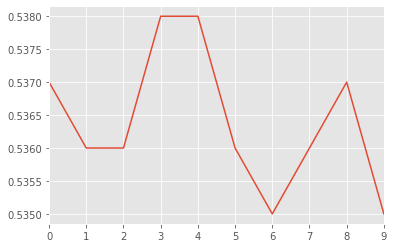

In [17]:
cols = [i for i in preds.columns if 'performance' in i]
temp = accs[cols]
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols

temp['LRE'].plot()
plt.savefig('round.svg', bbox_inches='tight')

plt.show()

In [259]:
def get_matrix_pl(e, c, col):
    

    filename = 'test.csv'
        
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', e[0], e[1], e[2], 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
    print(data.columns)
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            profit.loc[i/100, j/100] = temp[col].sum()

    return profit


def get_matrix_roi(e, c, col, bem=False):
    
    filename = 'test.csv'
        
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', e[0], e[1], e[2], 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
        
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            
            nmatches = len(temp)
            if nmatches > 100:
                if bem:
                    profit.loc[i/100, j/100] = temp[col].sum()/nmatches
                else:
                    profit.loc[i/100, j/100] = temp[col].sum()/temp[col].abs().sum()
            else:
                profit.loc[i/100, j/100] = 0

    return profit

In [260]:
e = ['market','gw','LogisticRegression']
mats_pr_avg = dict()
mat = get_matrix_pl(e, c, BET_EV_PL_AVG)
col = "_".join([c,e[0]])
mats_pr_avg[col] = mat

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'm._id', 'm.ss.ch.nm',
       'm.ss.yi', 'm.id', 'm.th', 'm.ta', 'm.gh', 'm.ga', 'm.res.bts', 'm.rg',
       'm.odds.s.bts.y.t.cnt', 'm.odds.s.bts.y.t.avg', 'm.odds.s.bts.y.t.med',
       'm.odds.s.bts.y.t.max', 'm.odds.s.bts.y.t.min', 'm.odds.s.bts.y.t.std',
       'm.odds.s.bts.y.o.cnt', 'm.odds.s.bts.y.o.avg', 'm.odds.s.bts.y.o.med',
       'm.odds.s.bts.y.o.max', 'm.odds.s.bts.y.o.min', 'm.odds.s.bts.y.o.std',
       'm.odds.s.bts.n.t.cnt', 'm.odds.s.bts.n.t.avg', 'm.odds.s.bts.n.t.med',
       'm.odds.s.bts.n.t.max', 'm.odds.s.bts.n.t.min', 'm.odds.s.bts.n.t.std',
       'm.odds.s.bts.n.o.cnt', 'm.odds.s.bts.n.o.avg', 'm.odds.s.bts.n.o.med',
       'm.odds.s.bts.n.o.max', 'm.odds.s.bts.n.o.min', 'm.odds.s.bts.n.o.std',
       'm.odds.s.bts.ovr', 'm.odds.f.bts.f.c', 'm.odds.f.bts.f.v.cnt',
       'm.odds.f.bts.f.v.avg', 'm.odds.f.bts.f.v.med', 'm.odds.f.bts.f.v.max',
       'm.odds.f.bts.f.v.min', 'm.odds.f.bts.f.v.std', 'm.odd

KeyError: 'bet.ev.pl.avg'

In [264]:
import subprocess
x = subprocess.call ("/usr/bin/Rscript --vanilla /home/igormago/Desktop/dixon.r 'England A'", shell=True)
print(x)


2
